In [20]:
import json
def filter_annotations_by_image_list_and_map_categories(coco_annotation_file, image_list_file, output_file):
    # Load the COCO annotation file
    with open(coco_annotation_file, 'r') as f:
        coco_data = json.load(f)
    
    # Load the list of image files from the JSON file
    with open(image_list_file, 'r') as f:
        image_file_list = json.load(f)
    
    # Category mapping:
    category_mapping = {
        1: 3,  # 1 -> 3
        2: 1,  # 2 -> 1
        4: 0,  # 4 -> 0
        5: 2   # 5 -> 2
    }
    
    # Create a dictionary to map image filenames to their corresponding image IDs
    image_id_map = {image['file_name']: image['id'] for image in coco_data['images']}
    
    # Get the set of image IDs corresponding to the image file list
    image_ids = set(image_id_map[file_name] for file_name in image_file_list if file_name in image_id_map)
    
    # Filter the images and annotations for selected image IDs and apply category mapping
    filtered_images = []
    filtered_annotations = []
    image_ids_to_remove = set()  # Keep track of images that contain category 3
    
    # Step 1: Identify images with cyclist (category_id == 3)
    for annotation in coco_data['annotations']:
        if annotation['image_id'] in image_ids and annotation['category_id'] == 3:
            image_ids_to_remove.add(annotation['image_id'])
    
    # Step 2: Process images and annotations, exclude images with category 3
    for annotation in coco_data['annotations']:
        image_id = annotation['image_id']
        
        # Only process images not marked for removal
        if image_id in image_ids and image_id not in image_ids_to_remove:
            # Apply category mapping if the category is in the mapping
            if annotation['category_id'] in category_mapping:
                annotation['image_id'] = f"over300_{image_id}"
                annotation['category_id'] = category_mapping[annotation['category_id']]
                filtered_annotations.append(annotation)

    # Step 3: Filter out images that have category 3
    for image in coco_data['images']:
        if image['id'] in image_ids and image['id'] not in image_ids_to_remove:
            image['id'] = f"over300_{image['id']}"
            filtered_images.append(image)
    
    # Create the new COCO dataset structure with only the filtered annotations and images
    filtered_coco_data = {
        "images": filtered_images,
        "annotations": filtered_annotations,
        "categories": [
            {"id": 0, "name": "person"},  # Modify as per your category names
            {"id": 1, "name": "car"},
            {"id": 2, "name": "truck"},
            {"id": 3, "name": "bus"}
        ],  # New categories after mapping
        "licenses": coco_data.get('licenses', [])  # Keep licenses if they exist
    }
    
    # Save the filtered annotations to a new JSON file
    with open(output_file, 'w') as f:
        json.dump(filtered_coco_data, f, indent=4)
    
    print(f"Images containing category 3 (cyclists) have been removed: {image_ids_to_remove}")


# Example usage
output_file = 'filtered_annotations_with_mapping.json'  # Output file for the filtered annotations

# Call the function to filter annotations based on the image list and map categories
filter_annotations_by_image_list_and_map_categories(coco_annotation_file, image_list_file, output_file)

print(f"Filtered annotations with category mapping have been saved to {output_file}")


Images containing category 3 (cyclists) have been removed: {259, 645, 660, 406, 153, 666, 539, 31, 32, 289, 290, 548, 424, 174, 304, 432, 693, 705, 206, 86, 606, 484, 102, 615, 105, 363, 236, 628, 503}
Filtered annotations with category mapping have been saved to filtered_annotations_with_mapping.json


NameError: name 'image_ids_to_remove' is not defined

In [18]:
coco_annotation_file= '/workspace/MLV_IR_OD/datasets/vehicles-and-pedestrians/labels/test_annotations.json'
image_list_file = '/workspace/MLV_IR_OD/datasets/vehicles-and-pedestrians/bbox_over300_car.json'

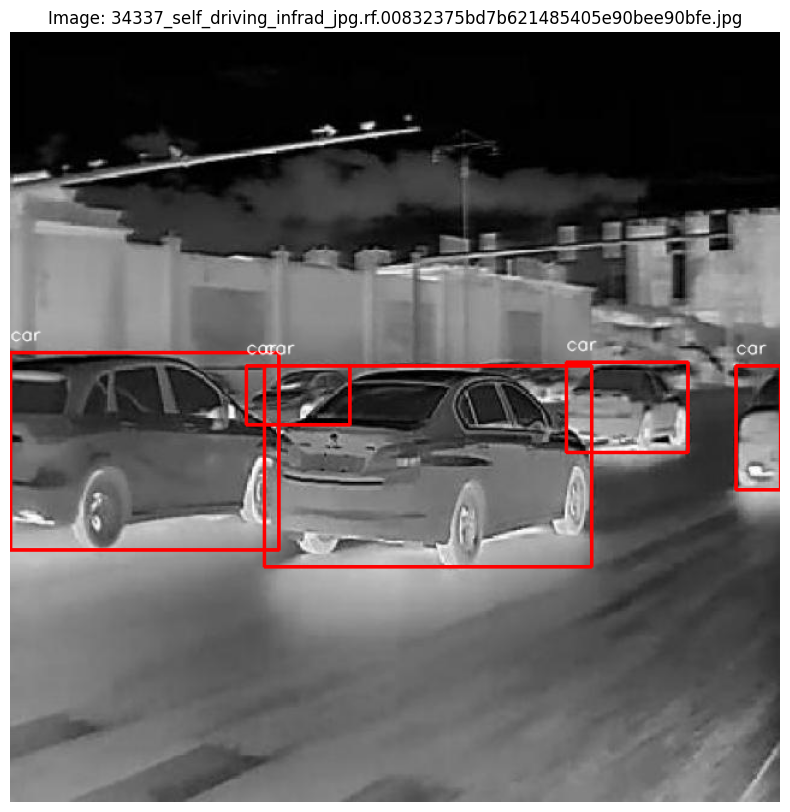

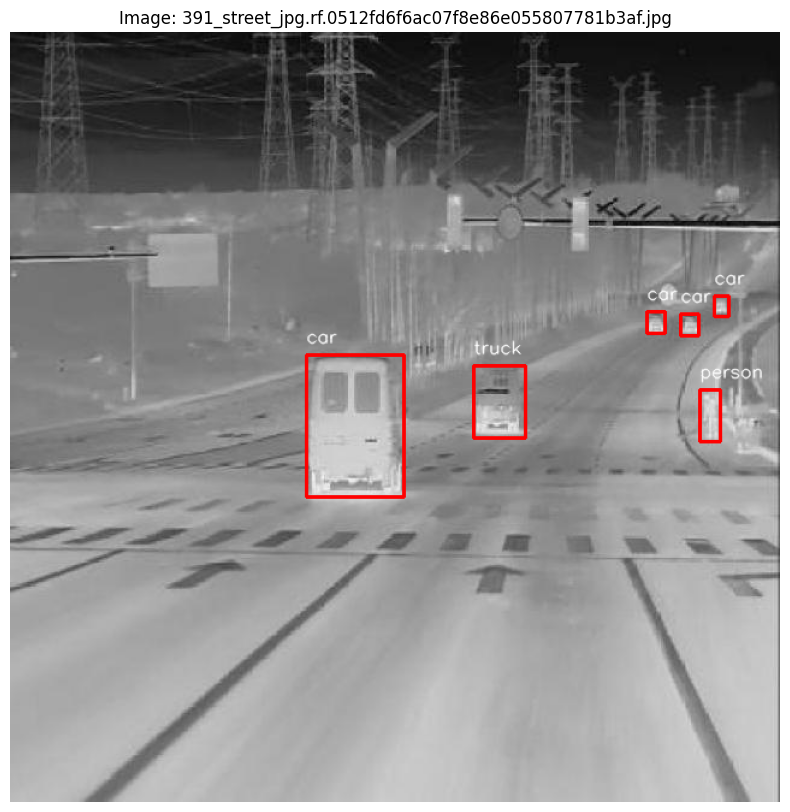

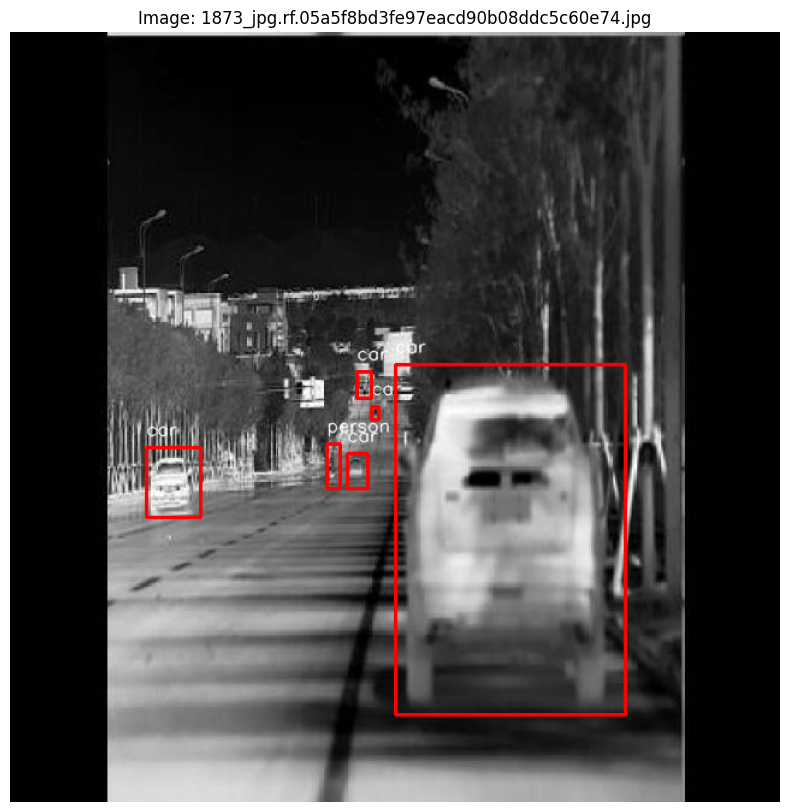

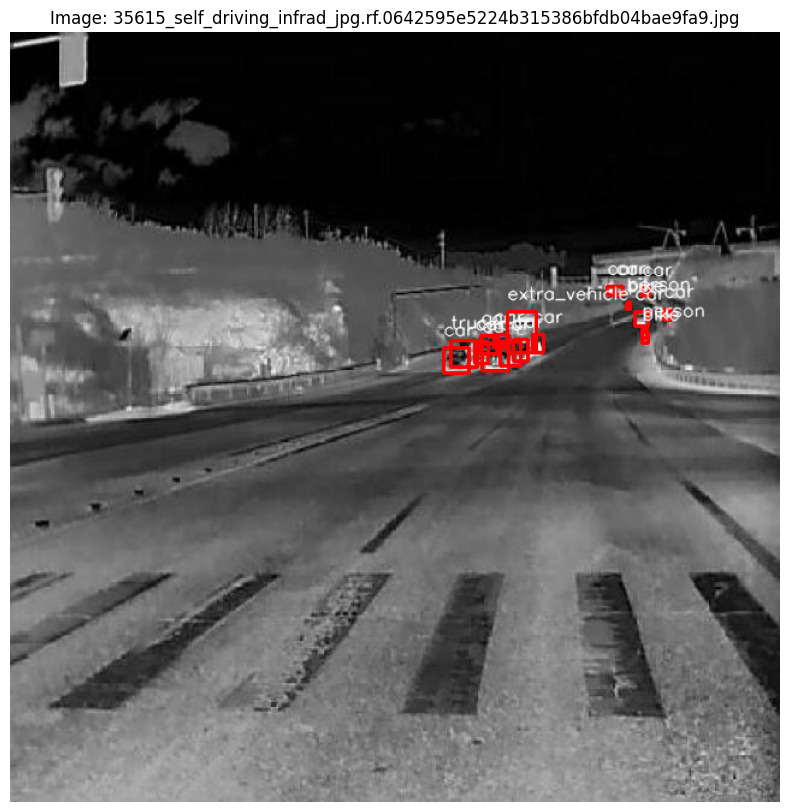

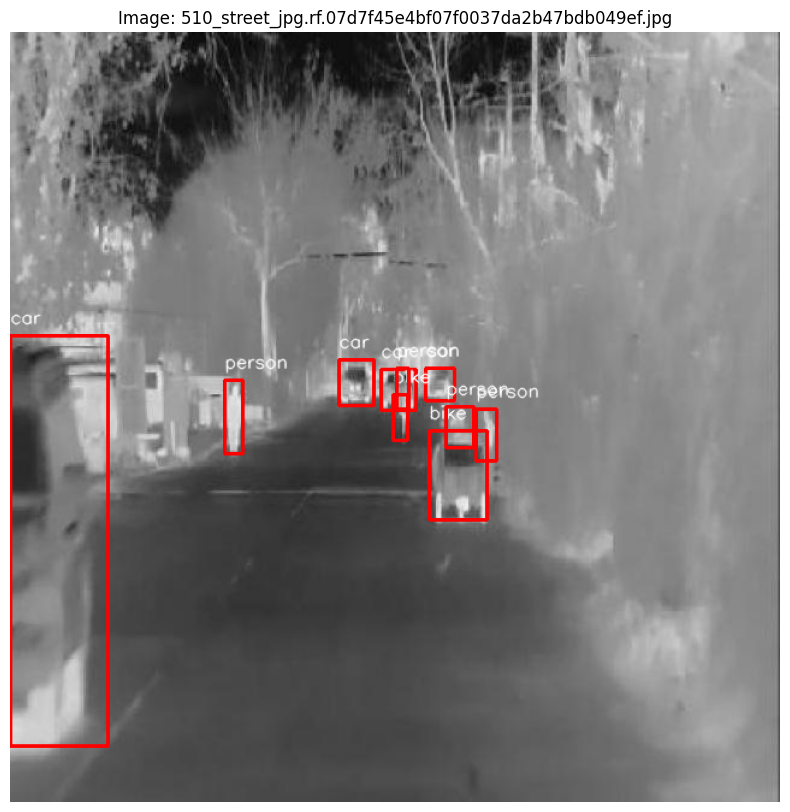

In [26]:
import json
import cv2
import matplotlib.pyplot as plt

import json
import cv2
import matplotlib.pyplot as plt

# Function to visualize annotations with category names
def visualize_annotations_with_category_names(coco_annotation_file, image_folder, num_images_to_show=5):
    # Load the COCO annotation file
    with open(coco_annotation_file, 'r') as f:
        coco_data = json.load(f)
    
    # Create a dictionary to map image IDs to image metadata
    image_map = {image['id']: image for image in coco_data['images']}
    
    # Create a dictionary to map category IDs to category names
    category_map = {category['id']: category['name'] for category in coco_data['categories']}
    
    # Initialize a dictionary to hold annotations for each image
    image_annotations = {}
    
    # Organize annotations by image_id
    for annotation in coco_data['annotations']:
        image_id = annotation['image_id']
        if image_id not in image_annotations:
            image_annotations[image_id] = []
        image_annotations[image_id].append(annotation)
    
    # Loop through the image list and draw annotations
    for idx, image_id in enumerate(image_annotations.keys()):
        if idx >= num_images_to_show:  # Show only the specified number of images
            break
        
        # Get image metadata
        image_data = image_map[image_id]
        image_path = f"{image_folder}/{image_data['file_name']}"
        
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not load image {image_path}")
            continue
        
        # Convert the image from BGR (OpenCV default) to RGB (for Matplotlib)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Draw all annotations for this image
        for annotation in image_annotations[image_id]:
            # Get bounding box (x, y, width, height)
            bbox = annotation['bbox']
            x, y, width, height = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
            
            # Get the category name
            category_name = category_map[annotation['category_id']]
            
            # Draw the bounding box (blue box, thickness 2)
            cv2.rectangle(image_rgb, (x, y), (x + width, y + height), (255, 0, 0), 2)
            
            # Write the category name above the bounding box (white text, font scale 0.5)
            cv2.putText(image_rgb, category_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        
        # Display the image using Matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.title(f"Image: {image_data['file_name']}")
        plt.axis('off')  # Hide axes
        plt.show()

# Example usage
coco_annotation_file = '/workspace/MLV_IR_OD/datasets/vehicles-and-pedestrians/bicycles/result.json'  # JSON file with the filtered annotations
image_folder = '/workspace/MLV_IR_OD/datasets/vehicles-and-pedestrians/bicycles/images'  # Folder where the images are stored
num_images_to_show = 5  # Number of images you want to visualize

# Visualize the annotations
visualize_annotations_with_category_names(coco_annotation_file, image_folder, num_images_to_show)
